[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Exploring Different Vision Tasks with Florence-2

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/florence-2/)
[![arXiv](https://img.shields.io/badge/arXiv-2311.06242-b31b1b.svg)](https://arxiv.org/abs/2311.06242)

## Setup

### Configure your API keys

To run Florence-2, you need to provide your HuggingFace Token. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store HuggingFace Access Token under the name `HF_TOKEN`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat Nov  9 17:55:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   48C    P0             15W /   50W |     105MiB /   4096MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install extra dependencies

 Let's download the model checkpoint and configure it so that you can fine-tune it later on.

In [2]:
!pip install -q transformers flash_attn timm einops supervision==0.22.0rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.9/126.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.9 MB/s eta 0:00:00


### Download example data

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/g22/GitHub/notebooks/notebooks


**NONE:** Let's download few example images. Feel free to use your images or videos.

In [6]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/inference/license_plate_1.jpg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/handwritten-text.jpg -P {HOME}/data

## Load pre-trained Florence-2 model

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [9]:
import torch
from transformers import AutoModelForCausalLM, AutoProcessor

# CHECKPOINT = "microsoft/Florence-2-base-ft"
CHECKPOINT = "microsoft/Florence-2-large-ft"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

## Run inference with pre-trained Florence-2 model

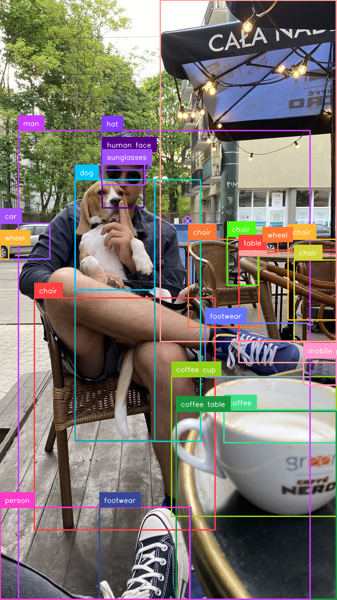

In [29]:
# @title Example object detection (`<OB>`) inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
text = "<OD>"
task = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=image.size)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

**NOTE:** Note that out of the box Florence-2 detects far more classes than the typical model pretreated on the COCO dataset.

In [7]:
 # @title Wrap inference code into utility function

def run_inference(image: Image, task: str, text: str = ""):
    prompt = task + text
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(generated_text, task=task, image_size=image.size)

**NOTE:** Florence-2 offers 3 types of imag caption tasks - `<CAPTION>`, `<DETAILED_CAPTION>`, `<MORE_DETAILED_CAPTION>` differing in level of detail. Let's compare the results obtained.

In [28]:
# @title Example `<CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<CAPTION>"

response = run_inference(image=image, task=task)
response

{'<CAPTION>': 'A man sitting in a chair holding a dog.'}

In [27]:
# @title Example `<DETAILED_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<DETAILED_CAPTION>': 'In this image I can see a person sitting on the chair and holding a dog. There is a cup and a mobile on the table. There are chairs and tables. At the back there is a building and there are trees.'}

In [26]:
# @title Example `<MORE_DETAILED_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<MORE_DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<MORE_DETAILED_CAPTION>': 'A man is sitting outside on a wicker chair. He is wearing a black cap, sunglasses and a blue shirt. The man is holding a brown and white dog in his lap. There is a black table in front of the man with a white coffee cup on it. Part of a building can be seen behind the man. Large green trees are standing on the side of the building.'}

Detections(xyxy=array([[240.84001, 732.8    , 293.40002, 942.72   ],
       [159.48001, 382.08   , 428.76   , 941.44   ],
       [160.20001, 382.08   , 330.84003, 941.44   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['tail', 'dog', 'dog'], dtype='<U4')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


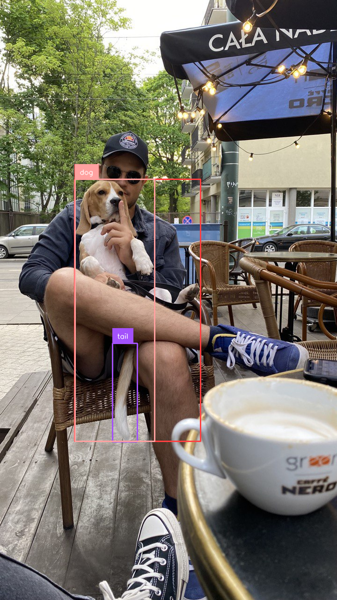

In [12]:
# @title Example `<CAPTION_TO_PHRASE_GROUNDING>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = "tail, shue, dog"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)
print(detections)
image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In this image I can see a person sitting on the chair and holding a dog. There is a cup and a mobile on the table. There are chairs and tables. At the back there is a building and there are trees.


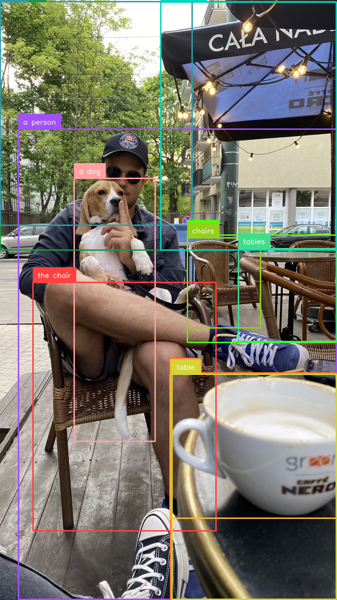

In [24]:
# @title Example `<DETAILED_CAPTION>` + `<CAPTION_TO_PHRASE_GROUNDING>` combo inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
text = response[task]

task = "<CAPTION_TO_PHRASE_GROUNDING>"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))

print(text)
image

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


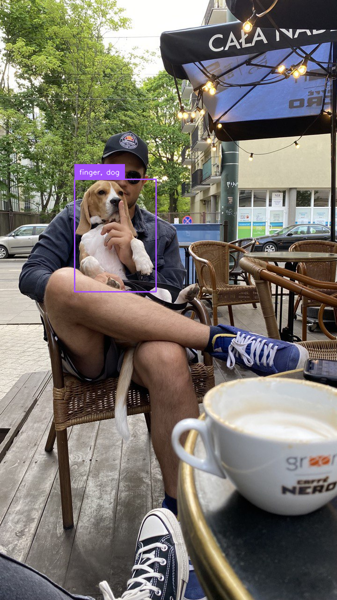

In [11]:
# @title Example `<OPEN_VOCABULARY_DETECTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<OPEN_VOCABULARY_DETECTION>"
text = "finger, dog"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

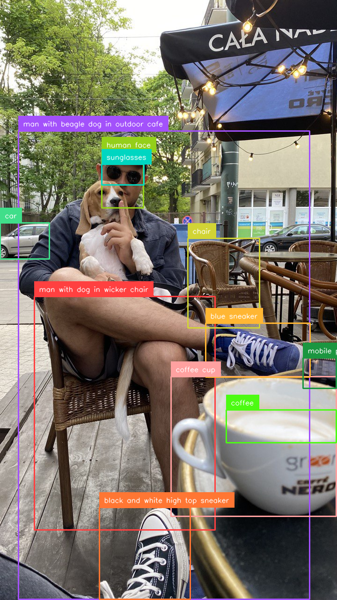

In [51]:
# @title Example `<DENSE_REGION_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DENSE_REGION_CAPTION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

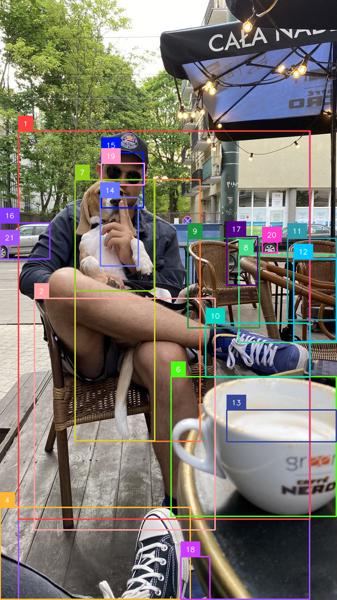

In [52]:
# @title Example `<REGION_PROPOSAL>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<REGION_PROPOSAL>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

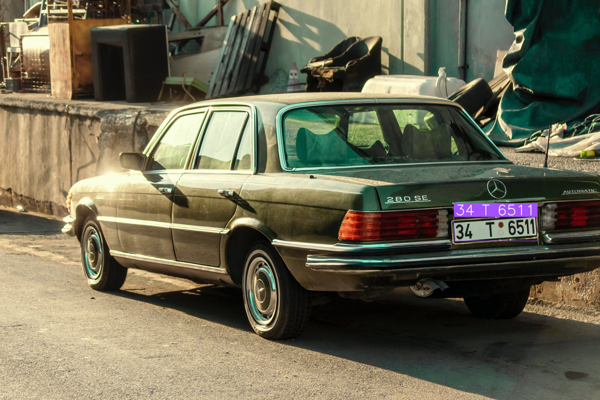

In [23]:
# @title Example `<OCR_WITH_REGION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/license_plate_1.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_scale=3,
    text_thickness=4
)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

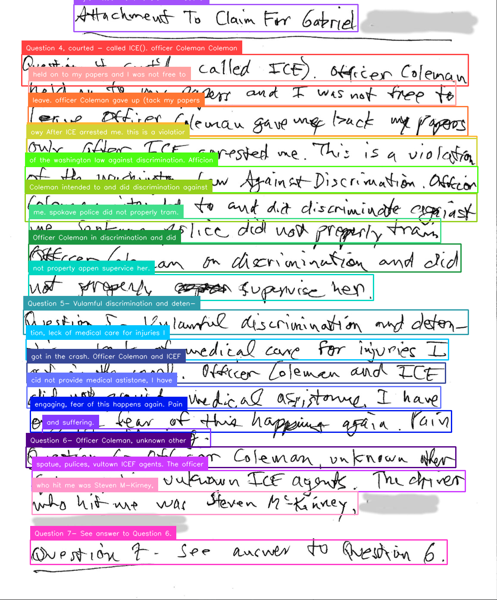

In [37]:
import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/handwritten-text.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [40]:
# @title Example `<OCR>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/handwritten-text.jpg")
task = "<OCR>"

response = run_inference(image=image, task=task)
response[task]

'Attachment To Claim For GatrielQuestion 4, cortfd - called ICE). officer Coleman Colemanheld on to my papers and I was not free toleave. Officer Coleman gave up (tuck my papersowy after ICE arrest me. This is a violationof the washington law against discrimination. AfficiorColeman intended to and did not discrimination exceptiastme. spokave police did not properly tran.Officer Coleman in discrimination and dichot property appen supervice her.Question 5- Vulamful discrimination and deten-tion, lack of medical care for injuries Igot in the crash. OfficerColeman and ICEFCid not provide medical astistone, I haveengaging fear of this happiness again. Painand suffering.Question 6- Officer Coleman, unknown otherspatue, pulices, vultown ICE agents. The officerwho hit me was Steven M-kirney,Question 7- See answer to Question 6.'

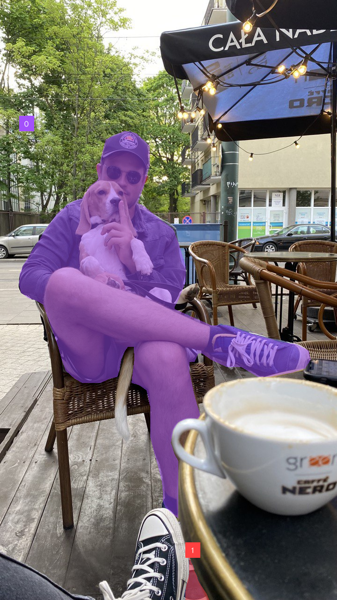

In [61]:
# @title Example `<REFERRING_EXPRESSION_SEGMENTATION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<REFERRING_EXPRESSION_SEGMENTATION>"
text = "man"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = mask_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [50]:
!pip install -q jupyter_bbox_widget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.6 MB/s eta 0:00:00


In [62]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [64]:
IS_COLAB = True
IMAGE_PATH = f"{HOME}/data/dog-3.jpeg"

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [138]:
widget.bboxes

[{'x': 156, 'y': 381, 'width': 276, 'height': 558, 'label': ''}]

In [139]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 243, 'y': 733, 'width': 52, 'height': 211, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

image = Image.open(IMAGE_PATH)
w, h = image.size
box = box / np.array([w, h, w, h])
box = box * 1000
box = box.astype(np.int32)
box

array([216, 297, 600, 733], dtype=int32)

In [140]:
region = "".join([f"<loc_{coordinate}>" for coordinate in box])
region

'<loc_216><loc_297><loc_600><loc_733>'

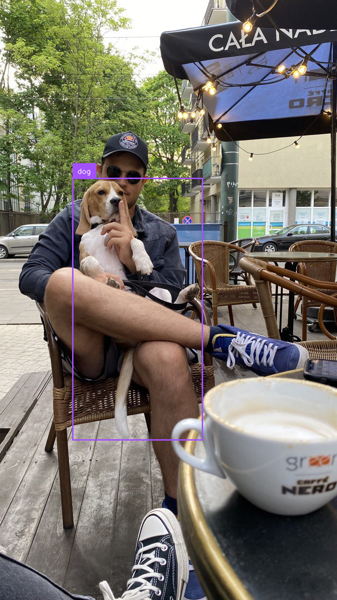

In [143]:
# @title Example `<REGION_TO_CATEGORY>` inference

import supervision as sv
from PIL import Image

task = "<REGION_TO_CATEGORY>"
image = Image.open(IMAGE_PATH)

response = run_inference(image=image, task=task, text=region)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
detections.xyxy = (detections.xyxy / 1000 * np.array([w, h, w, h])).astype(np.int32)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)

image.thumbnail((600, 600))
image

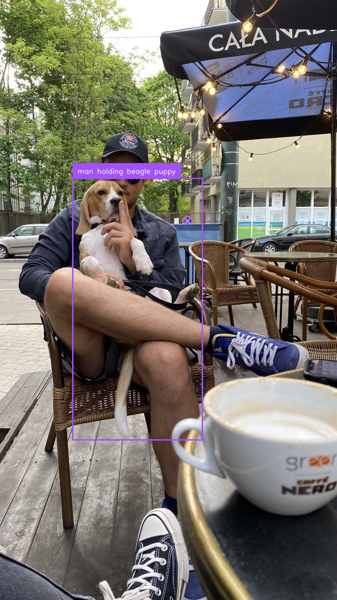

In [144]:
# @title Example `<REGION_TO_DESCRIPTION>` inference

import supervision as sv
from PIL import Image

task = "<REGION_TO_DESCRIPTION>"
image = Image.open(IMAGE_PATH)

response = run_inference(image=image, task=task, text=region)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
detections.xyxy = (detections.xyxy / 1000 * np.array([w, h, w, h])).astype(np.int32)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)

image.thumbnail((600, 600))
image

# Congratulations

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️